# MCMC diagnostics with [Arviz](https://python.arviz.org/)

This tutorial shows how to evaluate the quality of MCMC samples generated via `sbi` using the `arviz` package. 

We demonstrate this case using the trial-based simulator presented in Tutorial 14: A toy simulator mimicking the drift-diffusion model of decision-making. 

Outline:

1) Train MNLE to approximate the likelihood underlying the simulator
2) Run MCMC using `pyro` MCMC samplers via `sbi` interface
3) Use `arviz` to visualize the posterior, predictive distributions and MCMC diagnostics. 

In [1]:
import arviz as az
import torch

from sbi.inference import MNLE, likelihood_estimator_based_potential
from pyro.distributions import InverseGamma
from torch.distributions import Beta, Binomial, Gamma
from sbi.utils import MultipleIndependent

from sbi.inference import MCMCPosterior

# Seeding
torch.manual_seed(1);

In [2]:
# Toy simulator for mixed data
def mixed_simulator(theta):
    beta, ps = theta[:, :1], theta[:, 1:]

    choices = Binomial(probs=ps).sample()
    rts = InverseGamma(concentration=2 * torch.ones_like(beta), rate=beta).sample()

    return torch.cat((rts, choices), dim=1)


# Define independent priors for each dimension.
prior = MultipleIndependent(
    [
        Gamma(torch.tensor([1.0]), torch.tensor([0.5])),
        Beta(torch.tensor([2.0]), torch.tensor([2.0])),
    ],
    validate_args=False,
)

## Train MNLE to approximate the likelihood

For details see [tutorial 14](https://www.mackelab.org/sbi/tutorial/14_multi-trial-data-and-mixed-data-types/). 

Here, we pass `mcmc_method="nuts"` in order to use the underlying [`pyro` No-U-turn sampler](https://docs.pyro.ai/en/1.8.1/mcmc.html#nuts), but it would work as well with other samplers (e.g. "slice_np_vectorized", "hmc"). 

Additionally, when calling `posterior.sample(...)` we pass `return_arviz=True` so that the [`Arviz InferenceData`](https://arviz-devs.github.io/arviz/api/generated/arviz.InferenceData.html#arviz.InferenceData) object is returned. This object gives us access to the wealth of MCMC diagnostics tool provided by `arviz`.

In [3]:
# Generate training data and train MNLE.
num_simulations = 10000
theta = prior.sample((num_simulations,))
x = mixed_simulator(theta)

trainer = MNLE(prior)
likelihood_estimator = trainer.append_simulations(theta, x).train()

/Users/janbolts/qode/sbi/sbi/neural_nets/mnle.py:60: UserWarning: The mixed neural likelihood estimator assumes that x contains
        continuous data in the first n-1 columns (e.g., reaction times) and
        categorical data in the last column (e.g., corresponding choices). If
        this is not the case for the passed `x` do not use this function.
  warnings.warn(


 Neural network successfully converged after 65 epochs.

## Run Pyro NUTS MCMC and obtain `arviz InferenceData` object

In [4]:
# Simulate "observed" data x_o
torch.manual_seed(42)
num_trials = 100
theta_o = prior.sample((1,))
x_o = mixed_simulator(theta_o.repeat(num_trials, 1))

# Set MCMC parameters and run Pyro NUTS.
mcmc_parameters = dict(
    num_chains=2,
    thin=2,
    warmup_steps=50,
    init_strategy="proposal",
    method="nuts",
)
num_samples = 1000

# get the potential function and parameter transform for constructing the posterior
potential_fn, parameter_transform = likelihood_estimator_based_potential(
    likelihood_estimator, prior, x_o
)
mnle_posterior = MCMCPosterior(
    potential_fn, proposal=prior, theta_transform=parameter_transform, **mcmc_parameters
)

mnle_samples, idata = mnle_posterior.sample(
    (num_samples,), x=x_o, return_arviz=True, show_progress_bars=False
)

/Users/janbolts/qode/sbi/sbi/utils/sbiutils.py:280: UserWarning: An x with a batch size of 100 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(


## Generate `arviz` plots

The resulting `InferenceData` object can be passed to most `arviz` plotting functions, and there are plenty see [here](https://arviz-devs.github.io/arviz/examples/index.html#) for an overview.

To get a better understanding of the `InferenceData` object see [here](https://arviz-devs.github.io/arviz/schema/schema.html). 

Below and overview of common MCMC diagnostics plot, see the corresponding `arviz` documentation for interpretation of the plots. 

We will a full use-case using the SBI-MCMC-arviz workflow soon.

In [5]:
idata

Inference data with groups:
	> posterior

### Diagnostic plots

array([<AxesSubplot:title={'center':'theta\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'theta\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

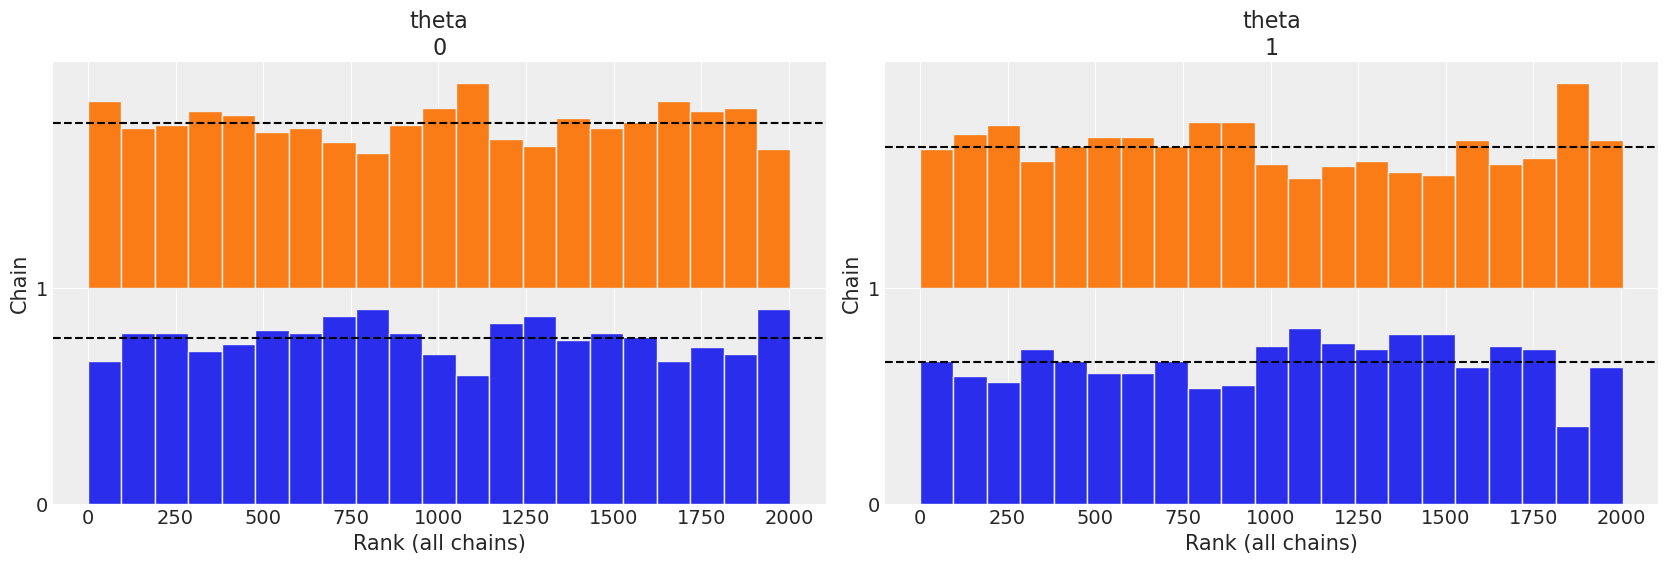

In [6]:
az.style.use("arviz-darkgrid")
az.plot_rank(idata)

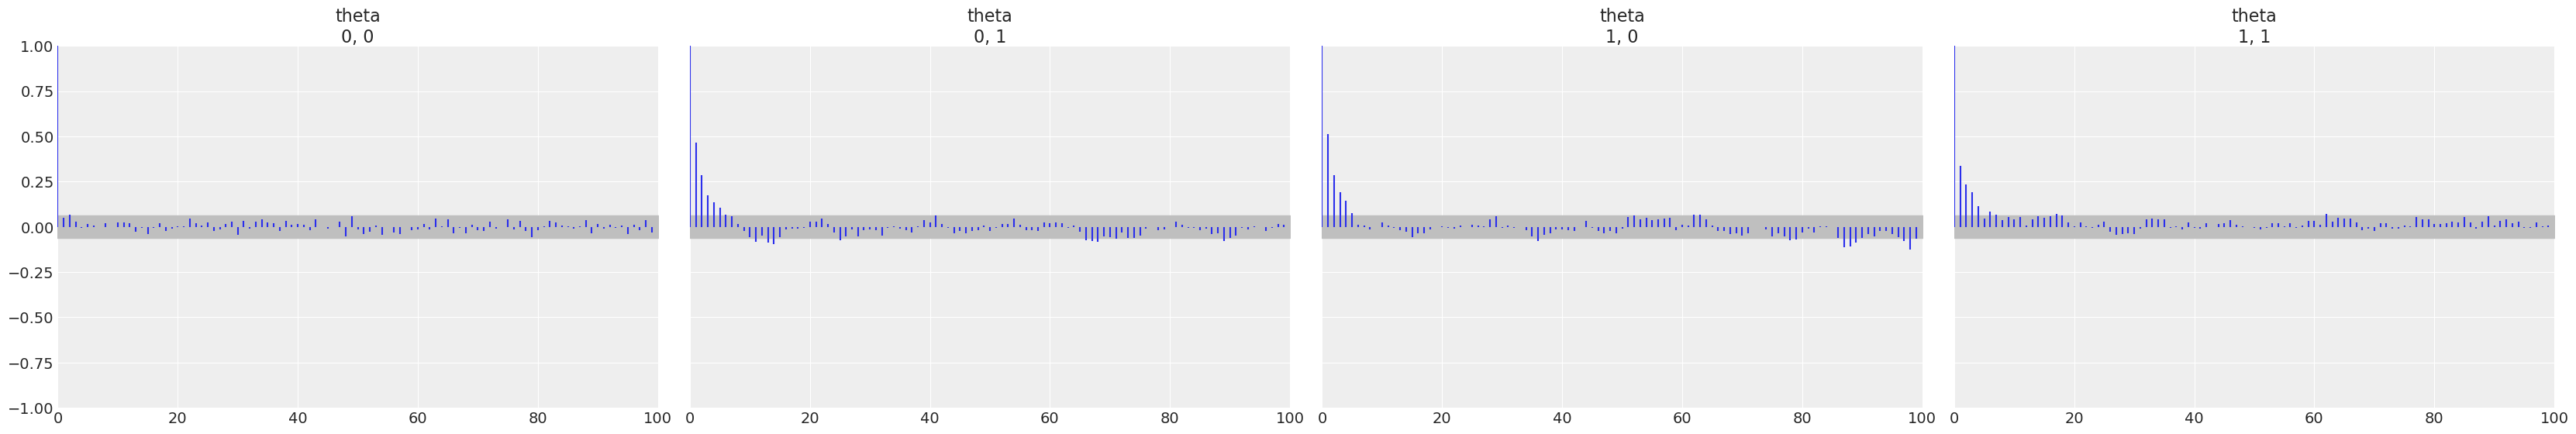

In [7]:
az.plot_autocorr(idata);

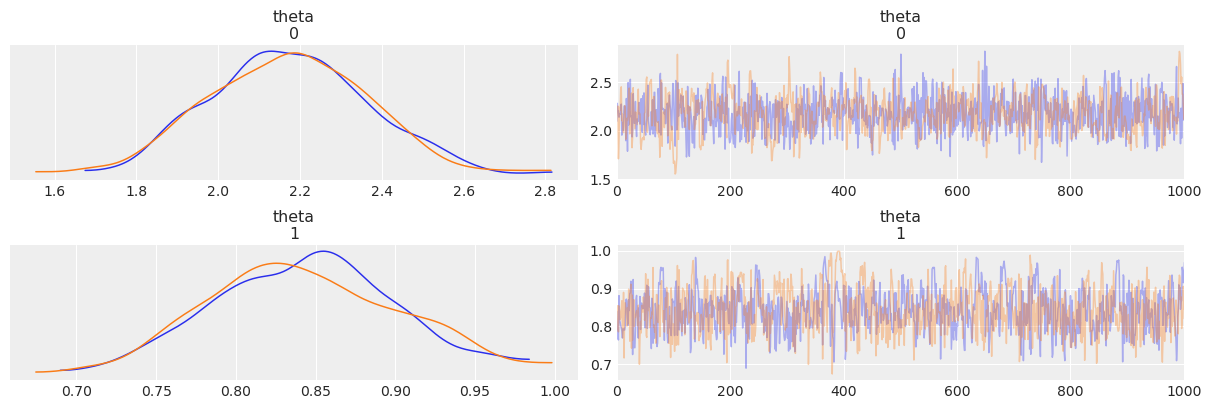

In [8]:
az.plot_trace(idata, compact=False);

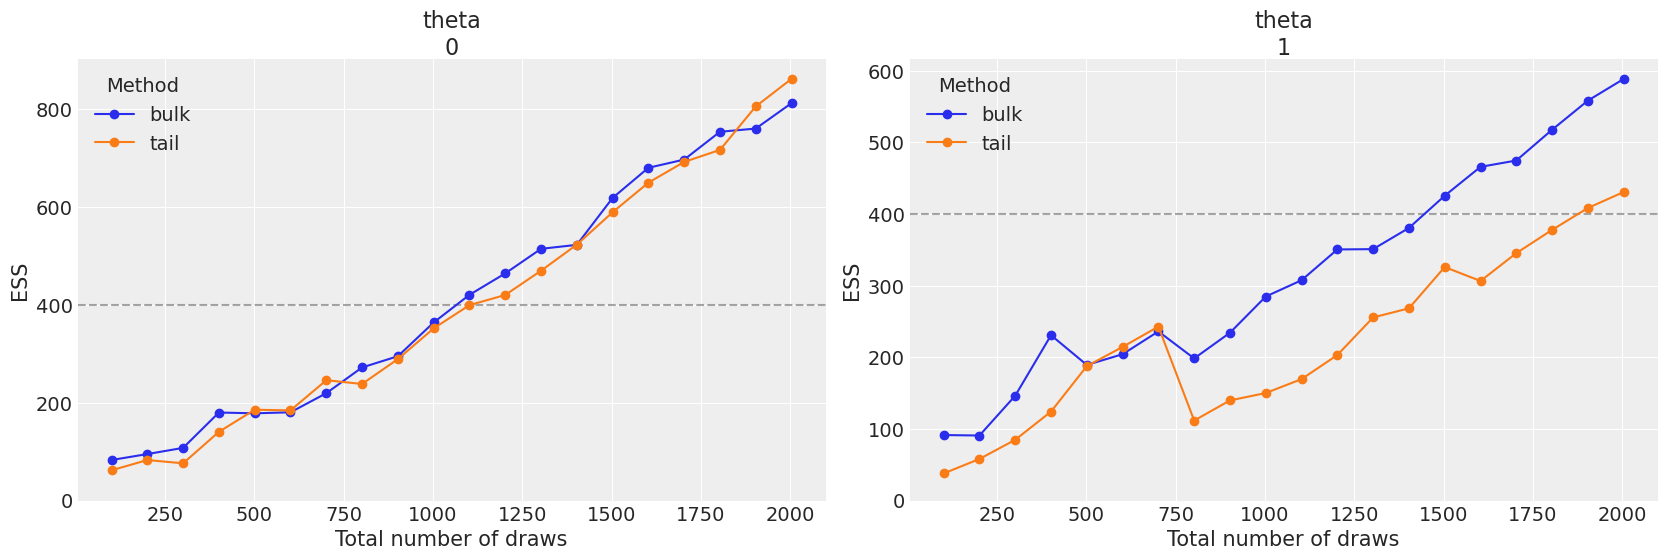

In [9]:
az.plot_ess(idata, kind="evolution");

### Posterior density  plots

array([<AxesSubplot:title={'center':'theta\n0'}>,
       <AxesSubplot:title={'center':'theta\n1'}>], dtype=object)

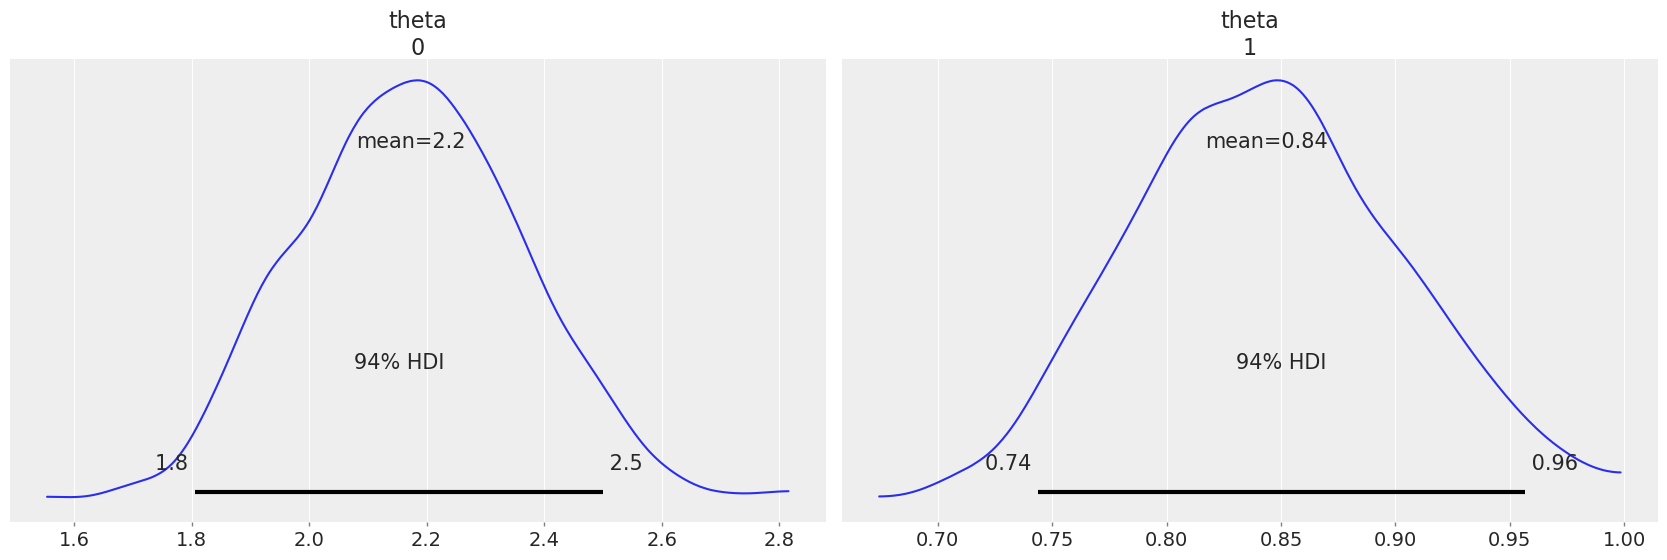

In [10]:
az.plot_posterior(idata)

In [11]:
print(
    f"Given the {num_trials} we observed, the posterior is centered around true underlying parameters theta_o: {theta_o}"
)

Given the 100 we observed, the posterior is centered around true underlying parameters theta_o: tensor([[1.9622, 0.7550]])


<AxesSubplot:xlabel='theta\n0', ylabel='theta\n1'>

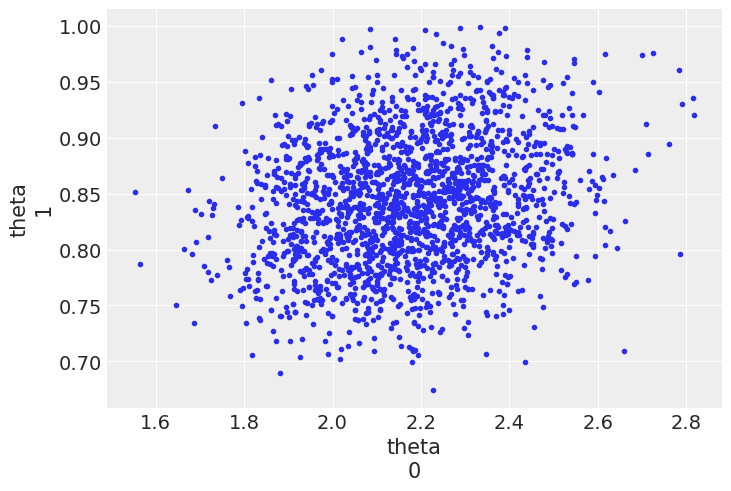

In [12]:
az.plot_pair(idata)

array([[<AxesSubplot:>, None],
       [<AxesSubplot:xlabel='theta\n0', ylabel='theta\n1'>,
        <AxesSubplot:>]], dtype=object)

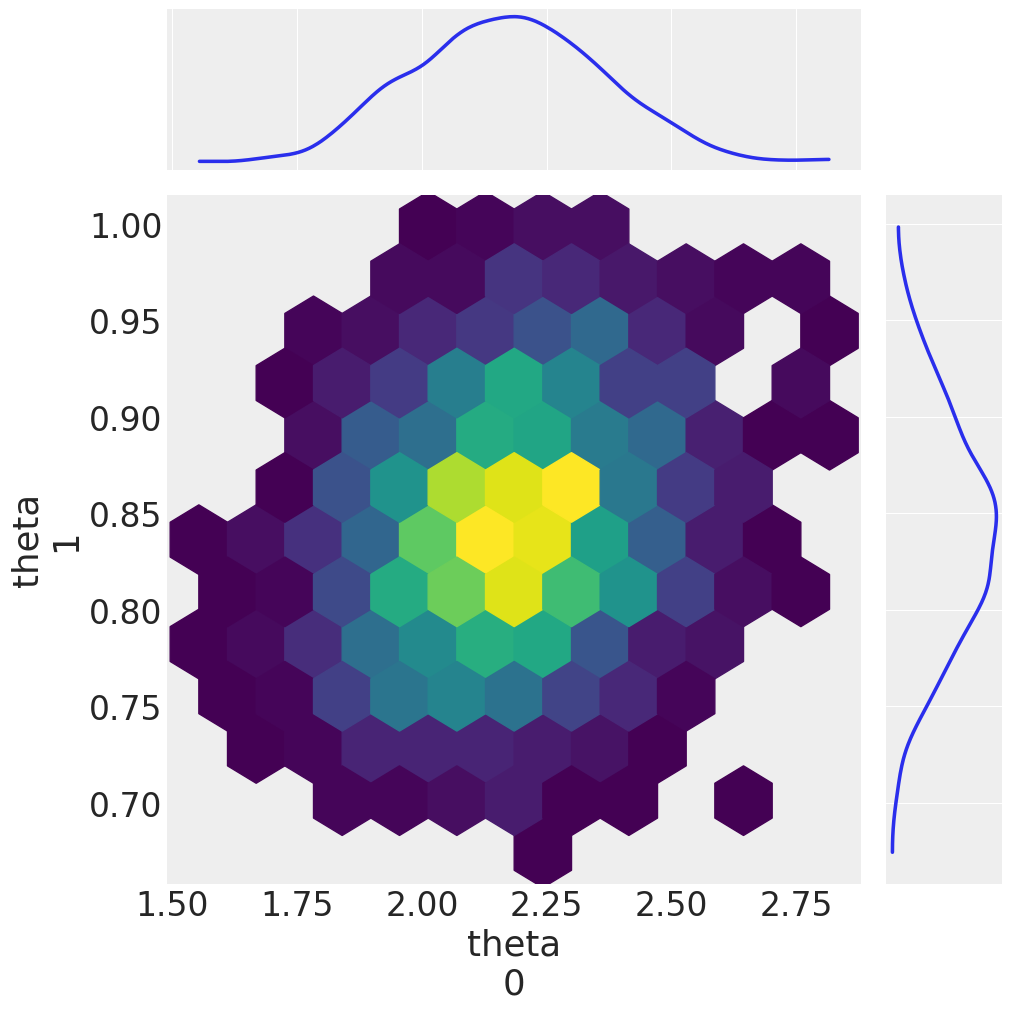

In [13]:
az.plot_pair(
    idata,
    var_names=["theta"],
    kind="hexbin",
    marginals=True,
    figsize=(10, 10),
)